<a href="https://colab.research.google.com/github/vaikunthd/Opioid-Prescription-Analysis-using-Machine-Learning/blob/main/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import itertools
!pip install chart_studio
import chart_studio.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.9 MB/s eta 0:00:00


In [2]:
import chart_studio
chart_studio.tools.set_credentials_file(username='VD05', api_key='V4AqQZUpZ37s85E69MXK')

In [3]:
df = pd.read_csv("/content/sample_data/prescriber-info.csv")
# load the file as pandas dataframe
opiate_df = pd.read_csv("/content/sample_data/opioids.csv")
# read the opiate drug file

# **Dropping of drugs that are opiate**

In [4]:
opiate = []
for col in opiate_df:
    for drug in opiate_df[col]:
        drug = drug.replace(" ", ".")
        drug = drug.replace("-", ".")
        for given in df.columns:
            if drug == given:
                opiate.append(given)
opiate = list(set(opiate))
df.drop(opiate, axis = 1, inplace = True)
df.head(5)

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,0,0,0,21,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


# **User defined functions**

In [5]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def performance_metrics(actual, predict):
    """
    This function evaluates the performance metrics
    needed.
    """

    accuracy = np.mean(actual == predict)
    # compute accuracy
    print("Accuracy: {0}%".format(accuracy*100))
    print("\nReport")
    print(metrics.classification_report(actual, predict))
    # classification report
    matrix = (metrics.confusion_matrix(actual, predict))
    plot_confusion_matrix(matrix, ['0', '1'])
    # plot the confusion matrix
    fpr, tpr, threshold = metrics.roc_curve(actual, predict)
    # values to plot ROC curve
    print("FPR")
    print(fpr)
    print("TPR")
    print(tpr)
    print("Thresholds")
    print(threshold)
    auc = round(metrics.roc_auc_score(actual, predict), 2)
    # get the area under curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {0})'.format(auc), color = 'green')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

In [7]:
def feature_graph(x, y, k = 10, filename = None):
    """
    Helps to plot the feature and its score
    """

    trace = go.Bar(
                   x = [i[0] for i in feature_imp[:k]],
                   y = [i[1] for i in feature_imp[:k]],
                   )
    data = [trace]
    layout = go.Layout(
        title='Top ten feature-scores',
        xaxis=dict(
            title = "Features",
            tickangle = 40,
            tickfont=dict(
                size=8,
                color='rgba(0, 0, 0, 1)'
            )
        ),
        yaxis=dict(
            title='Feature score',
            titlefont=dict(
                size=14,
                color='rgba(0, 0, 0, 1)'
            ),
            tickfont=dict(
                size=14,
                color='rgba(0, 0, 0, 1)'
            )
        ),
        plot_bgcolor = 'rgba(100, 100, 100, 0.04)'
    )

    fig = go.Figure(data=data, layout = layout)
    return py.iplot(fig, filename = filename)

# **Down sampling of data**

From Data_Exploration.ipynb file, we could see that the class distribution is skewed towards opioid prescriber. In order to eliminate this class imbalance, I performed downsampling. By this way we have a much more generalised classifier.

In [8]:
zero = df[df['Opioid.Prescriber'] == 0]
one = df[df['Opioid.Prescriber'] == 1]
# get the data of each class
if len(one) > len(zero):
    index = one.index[len(zero):]
else:
    index = zero.index[:len(one)]

df.drop(index, inplace = True)
# drop the rows to achieve balanced class labels

# **Data PreProcessing**

I developed the feature space by removing all the opioid drugs from the data as it is my response variable. I also removed metadata of doctors such as gender, state, NPI, credentials and specialty. Thus my feature space would be non-opioid drugs prescribed.

In [9]:
gender = df['Gender']
state = df['State']
specialty = df['Specialty']
columns = ['NPI', 'Credentials', 'Gender', 'State', 'Specialty']
# columns to be dropped
df.drop(labels = columns, axis = 1, inplace = True)
# drop the columns
df.head()

,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,134,0,0,15,...,0,0,0,0,0,0,0,0,35,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,0,0,0,0,21,0,0,0,0,58,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,19,0,...,0,0,0,0,17,28,0,0,0,1


In [10]:
labels = df['Opioid.Prescriber']
# get the class label values
features = df.drop(labels = 'Opioid.Prescriber', axis = 1)
# features for the data
features = pd.get_dummies(features)
# convert categorical data as features

In [11]:
df.corr()

,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
ABILIFY,1.000000,0.007272,0.086433,0.122855,0.046962,0.084728,0.311492,0.050051,0.196775,0.092352,...,0.040163,0.080952,0.045442,0.022414,0.147465,0.065847,0.057620,0.718053,0.349111,-0.047387
ACYCLOVIR,0.007272,1.000000,0.089203,0.086414,0.118153,0.174401,0.133355,0.028081,0.128419,0.166529,...,0.122715,0.067513,0.046149,0.075859,0.077634,0.046165,0.098220,-0.004242,0.140614,0.085291
ADVAIR.DISKUS,0.086433,0.089203,1.000000,0.262331,0.285814,0.399572,0.281976,0.132607,0.290322,0.449525,...,0.257444,0.194944,0.187570,0.175729,0.286094,0.153456,0.292932,0.020254,0.305433,0.147913
AGGRENOX,0.122855,0.086414,0.262331,1.000000,0.226804,0.397234,0.232511,0.171957,0.287040,0.426062,...,0.238564,0.233020,0.157100,0.162002,0.312387,0.193045,0.245830,0.041943,0.265477,0.116040
ALENDRONATE.SODIUM,0.046962,0.118153,0.285814,0.226804,1.000000,0.444750,0.259166,0.111571,0.281198,0.492334,...,0.300223,0.197652,0.270117,0.182255,0.216805,0.111718,0.303278,0.006380,0.285285,0.181694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XARELTO,0.065847,0.046165,0.153456,0.193045,0.111718,0.229903,0.159183,0.643215,0.137857,0.405586,...,0.259032,0.130118,0.072282,0.253598,0.322562,1.000000,0.369931,0.025600,0.161441,0.033824
ZETIA,0.057620,0.098220,0.292932,0.245830,0.303278,0.460119,0.309828,0.376003,0.325320,0.568456,...,0.370376,0.220760,0.208623,0.486891,0.315956,0.369931,1.000000,0.010173,0.340898,0.136506
ZIPRASIDONE.HCL,0.718053,-0.004242,0.020254,0.041943,0.006380,0.030582,0.242182,0.018827,0.162350,0.031428,...,0.010443,0.022868,0.005432,0.006940,0.034232,0.025600,0.010173,1.000000,0.260850,-0.060627
ZOLPIDEM.TARTRATE,0.349111,0.140614,0.305433,0.265477,0.285285,0.452573,0.641911,0.139624,0.458746,0.490907,...,0.320494,0.214794,0.192563,0.256417,0.221956,0.161441,0.340898,0.260850,1.000000,0.189338


# **Feature Engineering**

In [12]:
features.head()

,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,...,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,134,0,0,15,...,0,0,0,0,0,0,0,0,0,35
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25
3,0,0,0,0,21,0,0,0,0,58,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,19,0,...,0,0,0,0,0,17,28,0,0,0


# **Eliminate features based on variance**

Variance threshold is a feature selection method that was used on my dataset to eliminate low variance features in my feature set. This would essentially remove all features which would exhibit low variance across rows in my dataset.

For this feature selection method I set different thresholds into the model by calculating the variances across different percentiles and then using them to set threshold parameters in my model.

i.e, It will remove all the features that have the same values across all prescriptions.


In [13]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold()
xt = vt.fit_transform(features.values)
variances = vt.variances_

In [14]:
thresholds = np.percentile(variances, [1, 10, 20, 30, 40, 50])
# various thresholds to be tested on

In [15]:
depths = [i for i in range(1, 50, 5)]
# various depths to explore with

In [16]:
cv = ShuffleSplit(n_splits=5, test_size=0.4, random_state=0)
# define how data is to be splitted for CV

In [17]:
vt = VarianceThreshold(threshold = 0)
# initialize the variance
pipe = Pipeline([("vt", vt), ("tree", tree.DecisionTreeClassifier(criterion = "entropy"))])
# pipeline to work
params = {"vt__threshold":thresholds, "tree__max_depth":depths}
# parameters to be tested with
clf = GridSearchCV(pipe, param_grid = params, n_jobs=-1, cv = cv, scoring = "accuracy")
# test various parameters on the classifier
clf.fit(features.values, labels.values)
# fit the data

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.4, train_size=None),
             estimator=Pipeline(steps=[('vt', VarianceThreshold(threshold=0)),
                                       ('tree',
                                        DecisionTreeClassifier(criterion='entropy'))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [1, 6, 11, 16, 21, 26, 31, 36, 41,
                                             46],
                         'vt__threshold': array([ 14.5624157 ,  31.89762506,  57.22553337,  84.06395829,
       120.60706229, 184.98241743])},
             scoring='accuracy')

In [18]:
cv_results = clf.cv_results_

In [19]:
results_dict = {}
# empty dict
for j in range(len(cv_results['params'])):
        # iterate over the index of each parameter
        k = tuple(sorted(cv_results['params'][j].items()))
        # the key to the dict
        results_dict[k] = []
        # empty dict
        for i in range(5):
            # iterate over each CV
            results_dict[k].append(cv_results['split{0}_test_score'.format(i)][j])
            # append score to the dict
        results_dict[k] = np.mean(results_dict[k])*100
        # take the mean of all CV's


In [20]:
tree_depth, test_threshold, acc = [], [], []
for each in results_dict.items():
    tree_depth.append(each[0][0][-1])
    test_threshold.append(each[0][1][-1])
    acc.append(each[1])

result_df = pd.DataFrame()
result_df['Depth'] = tree_depth
result_df['Threshold'] = test_threshold
result_df['accuracy'] = acc

Text(0.5, 1.01, 'Depth Vs Accuracy graphs for various variance threshold')

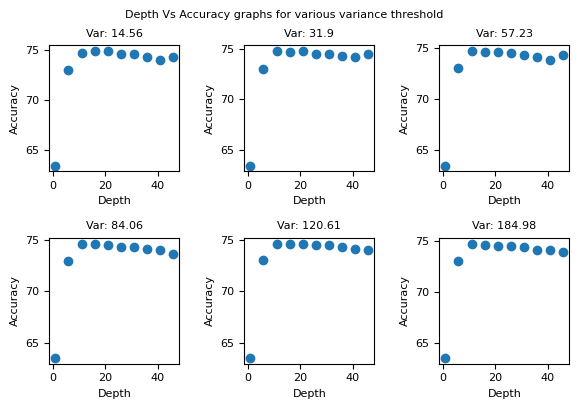

In [21]:
plt.figure(figsize = (6,4))
unique_threshold = sorted(result_df['Threshold'].unique())
for i in range(len(unique_threshold)):
    # iterate over each unique threshold
    data = result_df[result_df['Threshold'] == unique_threshold[i]]
    plt.subplot(2, 3, i+1)
    plt.scatter(data['Depth'], data['accuracy'])
    plt.title("Var: "+str(round(unique_threshold[i], 2)), fontsize = 8)
    plt.xlabel("Depth", fontsize = 8)
    plt.ylabel("Accuracy", fontsize = 8)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
plt.tight_layout()
plt.suptitle("Depth Vs Accuracy graphs for various variance threshold", fontsize = 8, y = 1.01)
#sns.lmplot('Depth', 'accuracy', hue = 'Threshold', data = result_df, fit_reg=False,palette=sns.color_palette("Blues"))

In [22]:
print("Best variance threshold")
print(clf.best_params_)

Best variance threshold
{'tree__max_depth': 21, 'vt__threshold': 14.562415700358287}


In [23]:
feature_variance_dict = sorted(zip(features.columns, variances), key = lambda x : x[1], reverse = True)
# get the feature variance dict
new_features = [f[0] for f in feature_variance_dict if f[1] > clf.best_params_['vt__threshold']]
# get the new features

# **Update feature space**

In [24]:
features = features[new_features]
# udpate the feature space
print(len(features.columns))
features.head()

236


,WARFARIN.SODIUM,TAMSULOSIN.HCL,LEVOTHYROXINE.SODIUM,FUROSEMIDE,LATANOPROST,OMEPRAZOLE,CLONAZEPAM,SIMVASTATIN,AMLODIPINE.BESYLATE,ATORVASTATIN.CALCIUM,...,DILTIAZEM.ER,VENLAFAXINE.HCL,TOPROL.XL,VYTORIN,AGGRENOX,SUMATRIPTAN.SUCCINATE,PROPRANOLOL.HCL.ER,FLOVENT.HFA,VALSARTAN,CARTIA.XT
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,31,0,0,85,16,51,15,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,24,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,18,0,48,0,52,0,80,58,13,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Top K feature selection using chi-square test**

I use the chi square test to test the dependence of each of the feature variables in the feature set to the target variable. If I find that the target variable is independent of the feature variable selected then I would remove it from my evaluation.

What it does is it takes the all feature values in my feature set which are non-opioid drugs prescribed as predictor and selects the top k features which describes the possibility whether a prescriber is opioid prescriber or not with values 1/0 as the response. It will check if there is any relationship between non opioid drugs and the opioid prescriber column.

In [25]:
top_k_features = list(np.linspace(20, len(features.columns), 6))
# top k features that we would like to get
top_k_features = [int(i) for i in top_k_features]
top_k_features

[20, 63, 106, 149, 192, 236]

In [26]:
top_k = SelectKBest(score_func = chi2, k = 1)
# method to get the top-k features using chi2 test
pipe = Pipeline([("topk", top_k), ("tree", tree.DecisionTreeClassifier(criterion = "entropy"))])
# pipeline to work
params = {"topk__k":top_k_features, "tree__max_depth":depths}
# parameters to be tested with
clf = GridSearchCV(pipe, param_grid = params, n_jobs=-1, cv = cv, scoring = "accuracy")
# test various parameters on the classifier
clf.fit(features.values, labels.values)
# fit the data

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.4, train_size=None),
             estimator=Pipeline(steps=[('topk',
                                        SelectKBest(k=1,
                                                    score_func=<function chi2 at 0x7a71b35a2830>)),
                                       ('tree',
                                        DecisionTreeClassifier(criterion='entropy'))]),
             n_jobs=-1,
             param_grid={'topk__k': [20, 63, 106, 149, 192, 236],
                         'tree__max_depth': [1, 6, 11, 16, 21, 26, 31, 36, 41,
                                             46]},
             scoring='accuracy')

In [27]:
cv_results = clf.cv_results_
results_dict = {}
# empty dict
for j in range(len(cv_results['params'])):
        # iterate over the index of each parameter
        k = tuple(sorted(cv_results['params'][j].items()))
        # the key to the dict
        results_dict[k] = []
        # empty dict
        for i in range(5):
            # iterate over each CV
            results_dict[k].append(cv_results['split{0}_test_score'.format(i)][j])
            # append score to the dict
        results_dict[k] = np.mean(results_dict[k])*100
        # take the mean of all CV's

In [28]:
tree_depth, test_top_k, acc = [], [], []
for each in results_dict.items():
    #print(each)
    tree_depth.append(each[0][1][-1])
    test_top_k.append(each[0][0][-1])
    acc.append(each[1])

result_df = pd.DataFrame()
result_df['depth'] = tree_depth
result_df['top_k'] = test_top_k
result_df['accuracy'] = acc

Text(0.5, 1.01, 'Depth Vs Accuracy graphs for various top K features')

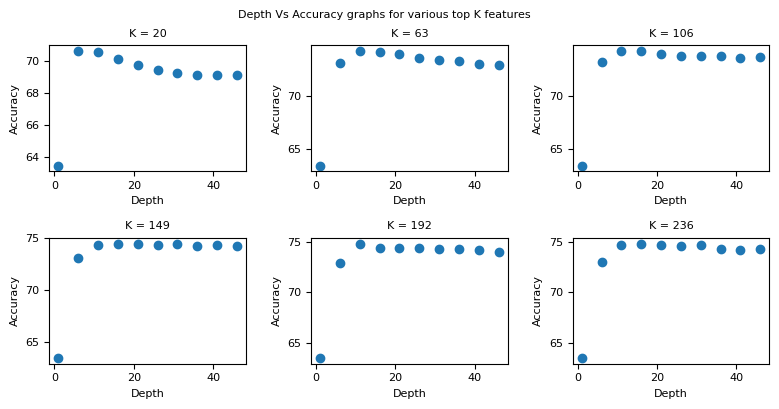

In [29]:
plt.figure(figsize = (8,4))
unique_val = sorted(result_df['top_k'].unique())

for i in range(len(unique_val)):
    # iterate over each unique threshold
    data = result_df[result_df['top_k'] == unique_val[i]]
    plt.subplot(2, 3, i+1)
    plt.scatter(data['depth'], data['accuracy'])
    plt.title("K = " + str(round(unique_val[i])), fontsize = 8)
    plt.xlabel("Depth", fontsize = 8)
    plt.ylabel("Accuracy", fontsize = 8)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
plt.tight_layout()
plt.suptitle("Depth Vs Accuracy graphs for various top K features", fontsize = 8, y = 1.01)
#sns.lmplot('Depth', 'accuracy', hue = 'Threshold', data = result_df, fit_reg=False,palette=sns.color_palette("Blues"))

In [30]:
print("Best Parameters")
print(clf.best_params_)

Best Parameters
{'topk__k': 192, 'tree__max_depth': 11}


In [31]:
top_k_clf = SelectKBest(score_func = chi2, k = clf.best_params_['topk__k'])
# selecting top K features
top_k_clf.fit_transform(features.values, labels.values)
# fit the data

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0, 31, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [32]:
feature_k_dict = sorted(zip(features.columns, top_k_clf.scores_), key = lambda x : x[1], reverse = True)
# get the feature variance dict
top_features = [f[0] for f in feature_k_dict][:clf.best_params_['topk__k']]
# get the top K features

In [33]:
features = features[top_features]
# updating the feature space
features.head()

,LEVOTHYROXINE.SODIUM,SIMVASTATIN,AMLODIPINE.BESYLATE,LISINOPRIL,OMEPRAZOLE,METFORMIN.HCL,GABAPENTIN,FUROSEMIDE,ATORVASTATIN.CALCIUM,HYDROCHLOROTHIAZIDE,...,PHENOBARBITAL,RALOXIFENE.HCL,VENLAFAXINE.HCL.ER,VYTORIN,ESTRADIOL,NASONEX,NIACIN.ER,CILOSTAZOL,ABILIFY,LAMOTRIGINE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,31,51,15,52,85,39,63,0,0,36,...,0,0,0,0,14,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,47,0,0,0,0,0,0,0
3,0,80,58,110,52,57,81,48,13,34,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Decision Tree Model**

Decision trees are being used for my analysis. The main reasons for using decision trees being that the decision trees

*   Divide the feature space into axis parallel rectangles , thus providing an easy method for distinctly dividing the feature set as opioid or non opioid based on the input feature set.
*   The target function is discrete valued and decision trees work well in predicting discrete valued target functions.


## **Validation curve**

In [34]:
train_scores, test_scores = validation_curve(tree.DecisionTreeClassifier(criterion="entropy"), features.values,
                                            labels.values, param_name = "max_depth", param_range  = np.linspace(1, 50, num = 50),
                                            scoring = "accuracy", n_jobs = -1, cv = 5)
# get the validation results for the decision tree across various depths

Text(0, 0.5, 'Score')

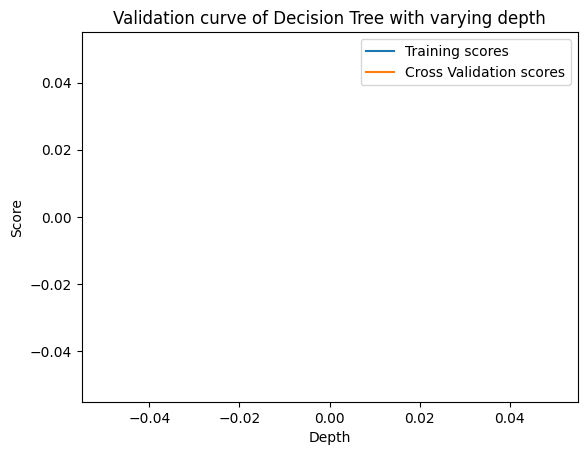

In [35]:
train_score_mean = np.mean(train_scores, axis = 1)
train_score_std = np.std(train_scores, axis = 1)
test_score_mean = np.mean(test_scores, axis = 1)
test_score_std = np.std(test_scores, axis = 1)

plt.plot(np.linspace(1, 50, num = 50), train_score_mean, label = "Training scores")
plt.plot(np.linspace(1, 50, num = 50), test_score_mean, label = "Cross Validation scores")
plt.fill_between(np.linspace(1, 50, num = 50), train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(np.linspace(1, 50, num = 50), test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Validation curve of Decision Tree with varying depth")
plt.xlabel("Depth")
plt.ylabel("Score")

## **Learning curve**

In [36]:
size = np.linspace(0.1, 1, 10)
# the size of train sets
train_sizes, train_scores, test_scores = learning_curve(tree.DecisionTreeClassifier(criterion="entropy", max_depth=11),
                                                   X=features.values, y = labels.values, cv = 5, n_jobs = -1,
                                               train_sizes = size)
# get the learning curve results for the data

Text(0, 0.5, 'Score')

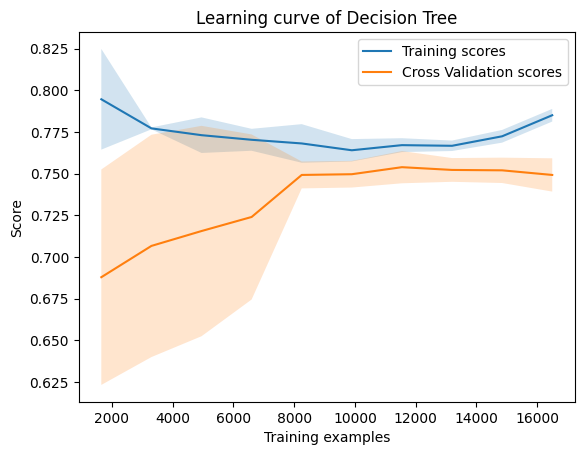

In [37]:
train_score_mean = np.mean(train_scores, axis = 1)
train_score_std = np.std(train_scores, axis = 1)
test_score_mean = np.mean(test_scores, axis = 1)
test_score_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_score_mean, label = "Training scores")
plt.plot(train_sizes, test_score_mean, label = "Cross Validation scores")
plt.fill_between(train_sizes, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(train_sizes, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Learning curve of Decision Tree")
plt.xlabel("Training examples")
plt.ylabel("Score")

In [38]:
best_clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth=clf.best_params_['tree__max_depth'])
# final best decision tree model
best_clf.fit(features.values, labels.values)
# fit data to classifier

DecisionTreeClassifier(criterion='entropy', max_depth=11)

In [39]:
predict = cross_val_predict(best_clf, X = features.values, y = labels.values, cv = 5, n_jobs = -1)
# predict class label based on CV

## **Performance metrics**

Accuracy: 75.00969743987588%

Report
              precision    recall  f1-score   support

           0       0.71      0.86      0.77     10312
           1       0.82      0.64      0.72     10312

    accuracy                           0.75     20624
   macro avg       0.76      0.75      0.75     20624
weighted avg       0.76      0.75      0.75     20624

Confusion matrix, without normalization
[[8842 1470]
 [3684 6628]]
FPR
[0.         0.14255237 1.        ]
TPR
[0.         0.64274631 1.        ]
Thresholds
[2 1 0]


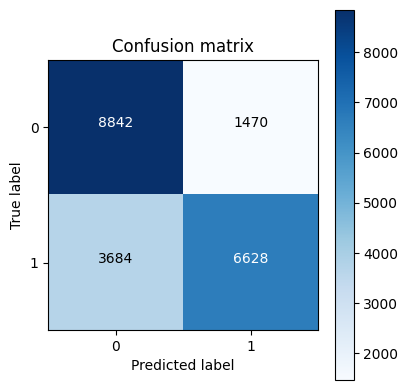

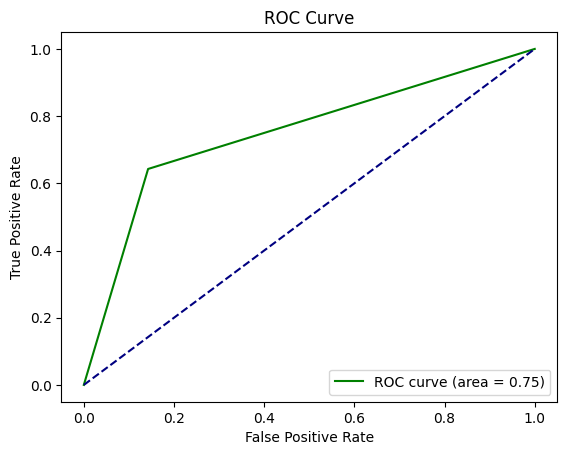

In [40]:
performance_metrics(labels, predict)
# function call to report performance metrics

## **Top 10 features**

In [41]:
feature_dict = dict(zip(features.columns, best_clf.feature_importances_))
# get the feature and its scores
feature_imp = sorted(feature_dict.items(), key = lambda x : x[1], reverse = True)
# sort based on feature score
x = [i[0] for i in feature_imp]
y = [i[1] for i in feature_imp]
# top 10 features
feature_graph(x, y, filename = "top-10-tree-with-feature-engg")
# plot the data

# **The top five features based on Decision Tree are as follows:**

*   Meloxicam (0.25) is a drug used to treat pain related to arthritis.
*  Ciprofloxacin (0.1)is a drug used to fight bacterial infections.
*   Gabapentin (0.06) is used to treat nerve pain caused by herpes virus.
*   Latanoprost(0.05) is used to treat increased pressure in
eyes.
*   Alprazolam (0.035) is used to treat panic disorder and anxiety.

We could see that drugs such as Meloxicam and Gabapentin are used for pain treatment as well, which is kind of what opioid does and likely gets prescribed at the same time.

# **Bagging wrapped with Decision Tree**

Bagging is the ensemble method that has been used here to better increase the performance of the model. Bagging reduces variance and prevents the models from overfitting the data.

For decision trees I draw a validation curve by embedding bagging in the decision tree model. I compared the training and the cross validation scores for different bags and I see how the model performs when the number of bags are varied. This helps me in understanding whether the overfitting of training data is being avoided and the decision tree model is generalised. For logistic regression a validation curve is drawn by varying the regularisation.

In [42]:
bagging_classifier = BaggingClassifier(tree.DecisionTreeClassifier(criterion="entropy", max_depth=clf.best_params_['tree__max_depth']))

param_range = list(range(1, 12, 5))
bag_train_scores, bag_test_scores = validation_curve(bagging_classifier, features.values,
                                            labels.values, param_name = "n_estimators", param_range  = param_range,
                                            scoring = "accuracy", n_jobs = -1, cv = 5)
# get the validation results for the decision tree across various depths

Text(0, 0.5, 'Score')

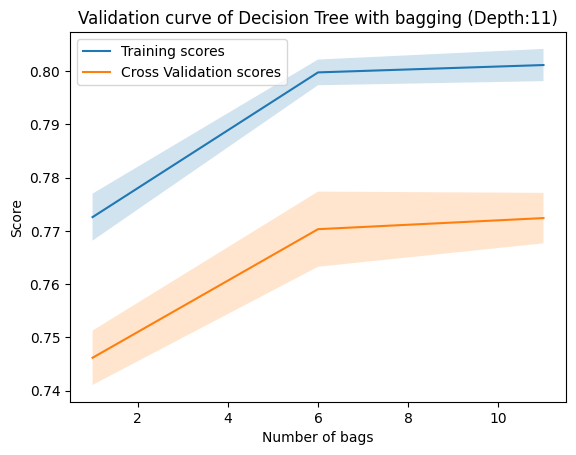

In [43]:
train_score_mean = np.mean(bag_train_scores, axis = 1)
train_score_std = np.std(bag_train_scores, axis = 1)
test_score_mean = np.mean(bag_test_scores, axis = 1)
test_score_std = np.std(bag_test_scores, axis = 1)

plt.plot(param_range, train_score_mean, label = "Training scores")
plt.plot(param_range, test_score_mean, label = "Cross Validation scores")
plt.fill_between(param_range, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(param_range, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Validation curve of Decision Tree with bagging (Depth:{0})".format(clf.best_params_['tree__max_depth']))
plt.xlabel("Number of bags")
plt.ylabel("Score")

In [44]:
bagging_classifier = BaggingClassifier(tree.DecisionTreeClassifier(criterion="entropy", max_depth=clf.best_params_['tree__max_depth']), n_estimators = 6)
# bagging classifier
bagging_classifier.fit(features.values, labels.values)

BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   max_depth=11),
                  n_estimators=6)

# **Logistic Regression**

*   Logistic regression was the other algorithm used in creating my model because logistic regression is better in predicting binary discrete target variables.
*   Logistic regression is better for predicting target variables having a decision boundary not parallel to the axis.
*   Logistic regression is less likely to over fit as it has lower variance compared to decision trees.

In [45]:
from sklearn import linear_model
labels = df['Opioid.Prescriber']
# get the class label values
features = df.drop(labels = 'Opioid.Prescriber', axis = 1)
# features for the data
features = pd.get_dummies(features)
# convert categorical data as features
features.head()

,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,...,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,134,0,0,15,...,0,0,0,0,0,0,0,0,0,35
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25
3,0,0,0,0,21,0,0,0,0,58,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,19,0,...,0,0,0,0,0,17,28,0,0,0


In [46]:
vt = VarianceThreshold()
xt = vt.fit_transform(features.values)
variances = vt.variances_
thresholds = np.percentile(variances, [1, 10, 20, 30, 40, 50])
# various thresholds to be tested on
c_val = [0.001, 0.01, 0.1, 1, 2]
# C values
vt = VarianceThreshold(threshold = 0)
# initialize the variance
pipe = Pipeline([("vt", vt), ("logistic", linear_model.LogisticRegression())])
# pipeline to work
params = {"vt__threshold":thresholds, "logistic__C":c_val}
# parameters to be tested with
clf = GridSearchCV(pipe, param_grid = params, n_jobs=-1, cv = cv, scoring = "accuracy")
# test various parameters on the classifier
clf.fit(features.values, labels.values)
# fit the data

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.4, train_size=None),
             estimator=Pipeline(steps=[('vt', VarianceThreshold(threshold=0)),
                                       ('logistic', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.001, 0.01, 0.1, 1, 2],
                         'vt__threshold': array([ 14.5624157 ,  31.89762506,  57.22553337,  84.06395829,
       120.60706229, 184.98241743])},
             scoring='accuracy')

In [47]:
cv_results = clf.cv_results_
results_dict = {}
# empty dict
for j in range(len(cv_results['params'])):
        # iterate over the index of each parameter
        k = tuple(sorted(cv_results['params'][j].items()))
        # the key to the dict
        results_dict[k] = []
        # empty dict
        for i in range(5):
            # iterate over each CV
            results_dict[k].append(cv_results['split{0}_test_score'.format(i)][j])
            # append score to the dict
        results_dict[k] = np.mean(results_dict[k])*100
        # take the mean of all CV's

c_value, test_threshold, acc = [], [], []
for each in results_dict.items():
    c_value.append(each[0][0][-1])
    test_threshold.append(each[0][1][-1])
    acc.append(each[1])

result_df = pd.DataFrame()
result_df['C'] = c_value
result_df['Threshold'] = test_threshold
result_df['accuracy'] = acc

Text(0.5, 1.01, 'C Vs Accuracy graphs for various variance threshold')

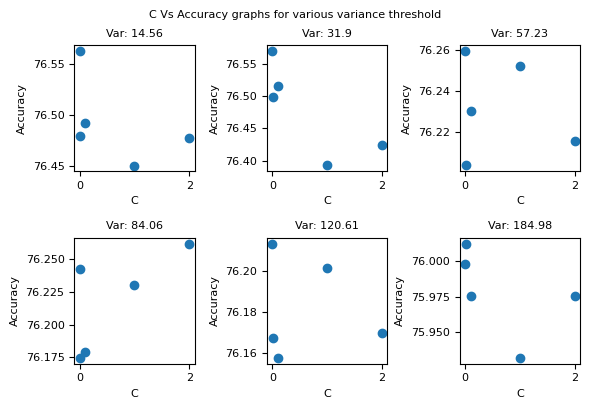

In [48]:
plt.figure(figsize = (6,4))
unique_threshold = sorted(result_df['Threshold'].unique())
for i in range(len(unique_threshold)):
    # iterate over each unique threshold
    data = result_df[result_df['Threshold'] == unique_threshold[i]]
    plt.subplot(2, 3, i+1)
    plt.scatter(data['C'], data['accuracy'])
    plt.title("Var: " + str(round(unique_threshold[i], 2)), fontsize = 8)
    plt.xlabel("C", fontsize = 8)
    plt.ylabel("Accuracy", fontsize = 8)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
plt.tight_layout()
plt.suptitle("C Vs Accuracy graphs for various variance threshold", fontsize = 8, y = 1.01)

In [49]:
print("Best parameters")
clf.best_params_

Best parameters


{'logistic__C': 0.001, 'vt__threshold': 31.897625059640383}

In [50]:
feature_variance_dict = sorted(zip(features.columns, variances), key = lambda x : x[1], reverse = True)
# get the feature variance dict
new_features = [f[0] for f in feature_variance_dict if f[1] > clf.best_params_['vt__threshold']]
# get the new features
features = features[new_features]
# udpate the feature space
features.head()

,WARFARIN.SODIUM,TAMSULOSIN.HCL,LEVOTHYROXINE.SODIUM,FUROSEMIDE,LATANOPROST,OMEPRAZOLE,CLONAZEPAM,SIMVASTATIN,AMLODIPINE.BESYLATE,ATORVASTATIN.CALCIUM,...,KLOR.CON.10,CEFUROXIME,METOLAZONE,BENICAR.HCT,METHOCARBAMOL,HYDROCORTISONE,ACYCLOVIR,HYDROXYZINE.HCL,NIACIN.ER,IPRATROPIUM.BROMIDE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,31,0,0,85,16,51,15,0,...,0,0,0,0,15,0,0,0,0,0
2,0,0,0,0,0,0,24,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,18,0,48,0,52,0,80,58,13,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Selecting top k features based on chi-square test**

In [51]:
top_k_features = list(np.linspace(20, len(features.columns), 6))
top_k_features = [int(i) for i in top_k_features]
print(top_k_features)
# top k features that we would like to get
top_k = SelectKBest(score_func = chi2, k = 1)
# method to get the top-k features using chi2 test
pipe = Pipeline([("topk", top_k), ("logistic", linear_model.LogisticRegression())])
# pipeline to work
c_val = [0.001, 0.01, 0.1, 1, 2]
params = {"topk__k":top_k_features, "logistic__C":c_val}
# parameters to be tested with
clf = GridSearchCV(pipe, param_grid = params, n_jobs=-1, cv = cv, scoring = "accuracy")
# test various parameters on the classifier
clf.fit(features.values, labels.values)
# fit the data

[20, 59, 98, 137, 176, 215]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.4, train_size=None),
             estimator=Pipeline(steps=[('topk',
                                        SelectKBest(k=1,
                                                    score_func=<function chi2 at 0x7a71b35a2830>)),
                                       ('logistic', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.001, 0.01, 0.1, 1, 2],
                         'topk__k': [20, 59, 98, 137, 176, 215]},
             scoring='accuracy')

In [52]:
cv_results = clf.cv_results_
results_dict = {}
# empty dict
for j in range(len(cv_results['params'])):
        # iterate over the index of each parameter
        k = tuple(sorted(cv_results['params'][j].items()))
        # the key to the dict
        results_dict[k] = []
        # empty dict
        for i in range(5):
            # iterate over each CV
            results_dict[k].append(cv_results['split{0}_test_score'.format(i)][j])
            # append score to the dict
        results_dict[k] = np.mean(results_dict[k])*100
        # take the mean of all CV's

c_value, test_top_k, acc = [], [], []
for each in results_dict.items():
    c_value.append(each[0][0][-1])
    test_top_k.append(each[0][1][-1])
    acc.append(each[1])

result_df = pd.DataFrame()
result_df['C'] = c_value
result_df['top_k'] = test_top_k
result_df['accuracy'] = acc
result_df.head()

,C,top_k,accuracy
0,0.001,20,69.578182
1,0.001,59,74.295758
2,0.001,98,75.144242
3,0.001,137,75.847273
4,0.001,176,76.215758


Text(0.5, 1.01, 'C Vs Accuracy graphs for various top K features')

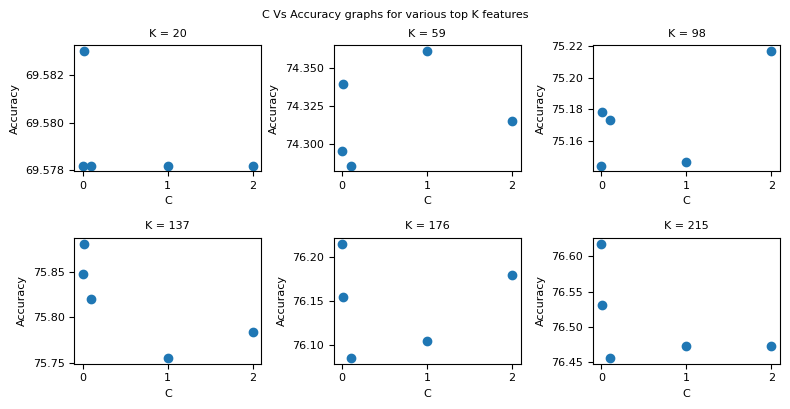

In [53]:
plt.figure(figsize = (8,4))
unique_val = sorted(result_df['top_k'].unique())

for i in range(len(unique_val)):
    # iterate over each unique threshold
    data = result_df[result_df['top_k'] == unique_val[i]]
    plt.subplot(2, 3, i+1)
    plt.scatter(data['C'], data['accuracy'])
    plt.title("K = " + str(round(unique_val[i])), fontsize = 8)
    plt.xlabel("C", fontsize = 8)
    plt.ylabel("Accuracy", fontsize = 8)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
plt.tight_layout()
plt.suptitle("C Vs Accuracy graphs for various top K features", fontsize = 8, y = 1.01)

In [54]:
clf.best_params_

{'logistic__C': 0.001, 'topk__k': 215}

In [55]:
top_k_clf = SelectKBest(score_func = chi2, k = clf.best_params_['topk__k'])
# selecting top K features
top_k_clf.fit_transform(features.values, labels.values)
# fit the data
feature_k_dict = sorted(zip(features.columns, top_k_clf.scores_), key = lambda x : x[1], reverse = True)
# get the feature variance dict
top_features = [f[0] for f in feature_k_dict][:clf.best_params_['topk__k']]
# get the top K features

features = features[top_features]
# updating the feature space
features.head()

,LEVOTHYROXINE.SODIUM,SIMVASTATIN,AMLODIPINE.BESYLATE,LISINOPRIL,OMEPRAZOLE,METFORMIN.HCL,GABAPENTIN,FUROSEMIDE,ATORVASTATIN.CALCIUM,HYDROCHLOROTHIAZIDE,...,QUETIAPINE.FUMARATE,OXCARBAZEPINE,NITROSTAT,METRONIDAZOLE,RANEXA,BUPROPION.XL,KETOCONAZOLE,SOTALOL,AMPHETAMINE.SALT.COMBO,PRADAXA
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,31,51,15,52,85,39,63,0,0,36,...,0,0,0,0,0,0,0,0,0,13
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,42,0,0,0,0
3,0,80,58,110,52,57,81,48,13,34,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Validation curve**

Text(0, 0.5, 'Score')

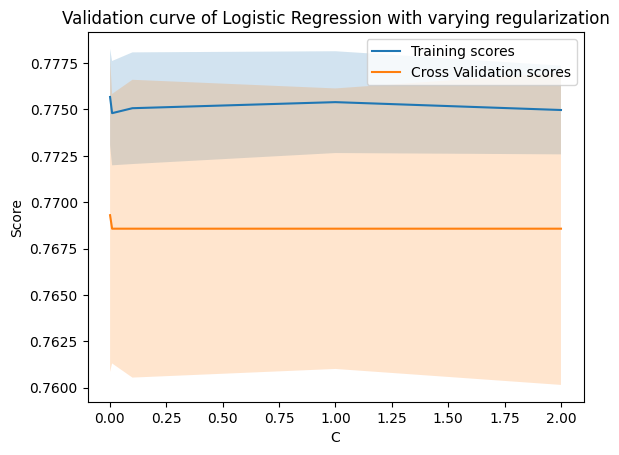

In [56]:
c_val = [0.001, 0.01, 0.1, 1, 2]
train_scores, test_scores = validation_curve(linear_model.LogisticRegression(), features.values,
                                            labels.values, param_name = "C", param_range  = c_val,
                                            scoring = "accuracy", n_jobs = -1, cv = 5)
# get the validation results for the decision tree across various depths

train_score_mean = np.mean(train_scores, axis = 1)
train_score_std = np.std(train_scores, axis = 1)
test_score_mean = np.mean(test_scores, axis = 1)
test_score_std = np.std(test_scores, axis = 1)

plt.plot(c_val, train_score_mean, label = "Training scores")
plt.plot(c_val, test_score_mean, label = "Cross Validation scores")
plt.fill_between(c_val, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(c_val, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Validation curve of Logistic Regression with varying regularization")
plt.xlabel("C")
plt.ylabel("Score")

# **Learning curve**

Text(0, 0.5, 'Score')

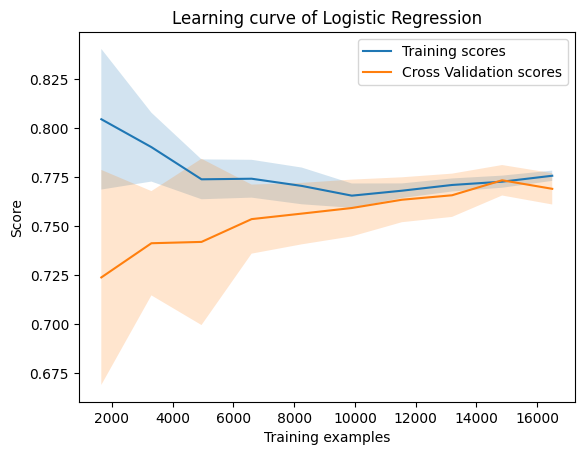

In [57]:
size = np.linspace(0.1, 1, 10)
# the size of train sets
train_sizes, train_scores, test_scores = learning_curve(linear_model.LogisticRegression(C=clf.best_params_['logistic__C']),
                                                   X=features.values, y = labels.values, cv = 5, n_jobs = -1,
                                               train_sizes = size)
# get the learning curve results for the data

train_score_mean = np.mean(train_scores, axis = 1)
train_score_std = np.std(train_scores, axis = 1)
test_score_mean = np.mean(test_scores, axis = 1)
test_score_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_score_mean, label = "Training scores")
plt.plot(train_sizes, test_score_mean, label = "Cross Validation scores")
plt.fill_between(train_sizes, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(train_sizes, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Learning curve of Logistic Regression")
plt.xlabel("Training examples")
plt.ylabel("Score")

# **Final Logistic Regression Model**

In [58]:
best_clf = linear_model.LogisticRegression(C = clf.best_params_['logistic__C'])
# final best decision tree model
best_clf.fit(features.values, labels.values)
# fit data to classifier

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=0.001)

In [59]:
predict = cross_val_predict(best_clf, X = features.values, y = labels.values, cv = 5, n_jobs = -1)
# predict class label based on CV

# **Performance metrics**

Accuracy: 76.92979053529868%

Report
              precision    recall  f1-score   support

           0       0.71      0.90      0.80     10312
           1       0.87      0.64      0.73     10312

    accuracy                           0.77     20624
   macro avg       0.79      0.77      0.77     20624
weighted avg       0.79      0.77      0.77     20624

Confusion matrix, without normalization
[[9301 1011]
 [3747 6565]]
FPR
[0.         0.09804112 1.        ]
TPR
[0.         0.63663693 1.        ]
Thresholds
[2 1 0]


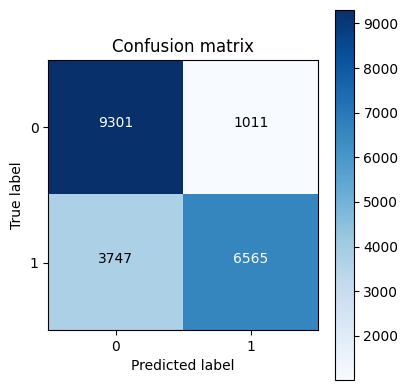

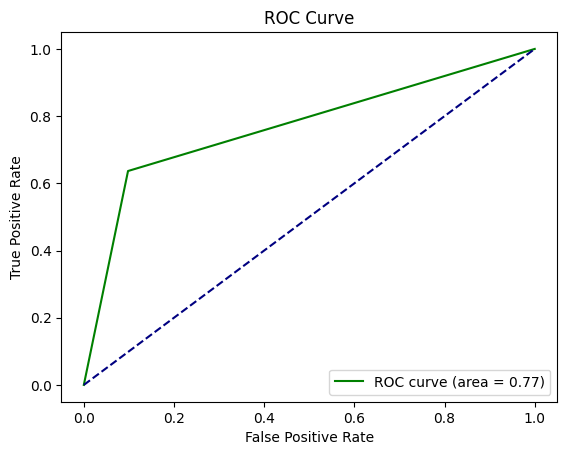

In [60]:
performance_metrics(labels, predict)
# function call to report performance metrics

# **Top 10 features**

In [61]:
feature_dict = dict(zip(features.columns, best_clf.coef_[0]))
# get the feature and its scores
feature_imp = sorted(feature_dict.items(), key = lambda x : x[1], reverse = True)
# sort based on feature score
x = [i[0] for i in feature_imp]
y = [i[1] for i in feature_imp]
# top 10 features
feature_graph(x, y, filename = "top-10-logistics-with-feature-engg")
# plot the data

# **The top five features based on Logistic Regression are as follows:**

*   Carisoprodol (0.14) is a muscle relaxer that works by blocking pain signals between the brain and nerves.
*   Methocarbamol (0.1) is also a muscle relaxer that blocks pain signals between brain and nerves.
*   Nabumetone (0.05) is used to treat pain and help relieve symptoms of arthritis.
*   Ondansetron.HCL (0.056) is used to prevent nausea and vomiting.
*   Lyrica(0.05) can block chemicals that sends pain signals to the nerves.

From this we can infer that top features have drugs which are used to treat pain that are related to nerves.

# **Conclusion:**

We succeeded in developing a pretty good opiate-prescription detection algorithm based primarily on prescriber’s prescription rates of non-opiate drugs and how it is influencing prescribers to also prescribe Opioids. Therefore, the method does give better results and can become a really good method if the problems and challenges can be solved. This could be utilised in a variety of ways to combat overdosing. We can analyse the situations in which a doctor prescribes opiate drugs and find other alternate drugs for that. Individual drugs with strong detectors may also be able to identify a sub-specialty of prescribers who may be of interest, or even expose secret pathways of illegal drug access.